In [1]:
!pip install numpy opencv-python scikit-learn matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 875.9 kB/s eta 0:00:00m eta 0:00:010:00:02


In [1]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import argparse
import pathlib
from collections import Counter



In [31]:
class ImageProcessor:
    def __init__(self, target_size=(64, 64)):
        """
        Initialize the ImageProcessor with a target size for image resizing.
        
        Parameters:
        target_size (tuple): The desired dimensions (width, height) to resize images.
        """
        self.target_size = target_size
        
    def load_and_preprocess_image(self, image_path):
        """
        Load an image, convert it to grayscale, resize it, normalize pixel values,
        and flatten it into a one-dimensional array.
        
        Parameters:
        image_path (str): The file path of the image.
        
        Returns:
        np.array: Flattened, normalized grayscale image.
        """
        img = cv2.imread(image_path)  # Read the image
        if img is None:
            raise ValueError(f"Could not load image at {image_path}")
            
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        img_resized = cv2.resize(img_gray, self.target_size)  # Resize the image
        img_normalized = img_resized / 255.0  # Normalize pixel values to [0, 1]
        
        return img_normalized.flatten()  # Flatten the image into a 1D array

    def load_dataset(self, base_path):
        """
        Load a dataset from a directory structure.
        The function assumes that stress images are in 'base_path' and non-stress
        images are in a sibling directory named 'NoStress'.
        
        Parameters:
        base_path (str): The directory containing stress images.
        
        Returns:
        tuple: (features, labels) where features is a NumPy array of processed images
               and labels is a NumPy array of corresponding class labels (1 for stress, 0 for no-stress).
        """
        features = []  # List to store image features
        labels = []  # List to store corresponding labels
        
        parent_dir = os.path.dirname(base_path)  # Get the parent directory
        
        # Load stress images
        stress_path = base_path
        print(f"Loading stress images from: {stress_path}")
        for img_name in tqdm(os.listdir(stress_path), desc="Loading stress images"):
            if img_name.endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')):
                img_path = os.path.join(stress_path, img_name)
                try:
                    img_features = self.load_and_preprocess_image(img_path)  # Process image
                    features.append(img_features)
                    labels.append(1)  # Label stress images as 1
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")
        
        # Load non-stress images from 'NoStress' folder
        no_stress_path = os.path.join(parent_dir, 'NoStress')
        print(f"Loading non-stress images from: {no_stress_path}")
        for img_name in tqdm(os.listdir(no_stress_path), desc="Loading non-stress images"):
            if img_name.endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')):
                img_path = os.path.join(no_stress_path, img_name)
                try:
                    img_features = self.load_and_preprocess_image(img_path)  # Process image
                    features.append(img_features)
                    labels.append(0)  # Label non-stress images as 0
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")
        
        return np.array(features), np.array(labels)  # Convert lists to NumPy arrays


In [32]:
processor = ImageProcessor(target_size=(64, 64))
stress_dir = '/home/axyl/codes/College/ml/KDEF/KDEF/Train/Stress'
features, labels = processor.load_dataset(stress_dir)


Loading stress images from: /home/axyl/codes/College/ml/KDEF/KDEF/Train/Stress


Loading stress images: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 3499/3499 [00:10<00:00, 346.92it/s]


Loading non-stress images from: /home/axyl/codes/College/ml/KDEF/KDEF/Train/NoStress


Loading non-stress images: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2802/2802 [00:06<00:00, 420.60it/s]


In [ ]:
import numpy as np
from tqdm import tqdm  # For displaying progress bar during training

class LogisticRegression:
    def __init__(self, learning_rate=0.001, num_iterations=10000):
        """
        Initialize the logistic regression model.
        
        Parameters:
        - learning_rate: Step size for gradient descent.
        - num_iterations: Number of iterations for training.
        """
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None  # Model weights (coefficients)
        self.bias = None  # Model bias (intercept)
        self.losses = []  # Store loss values for monitoring training progress
        
    def sigmoid(self, z):
        """
        Compute the sigmoid function, which maps input values to a probability range [0,1].
        
        Parameters:
        - z: The input value(s), which is typically a linear combination of weights and input features.
        
        Returns:
        - Sigmoid-transformed values.
        """
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))  # Clipping prevents overflow errors
    
    def fit(self, X, y, batch_size=32):
        """
        Train the logistic regression model using mini-batch gradient descent.
        
        Parameters:
        - X: Training data (features), shape (n_samples, n_features).
        - y: Training labels (binary: 0 or 1), shape (n_samples,).
        - batch_size: Number of samples per training batch (for mini-batch gradient descent).
        """
        n_samples, n_features = X.shape
        
        # Initialize weights and bias to zero
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Training loop
        for iteration in tqdm(range(self.num_iterations), desc="Training"):
            # Shuffle data indices to ensure randomness in mini-batch selection
            indices = np.random.permutation(n_samples)
            
            for i in range(0, n_samples, batch_size):
                # Select a mini-batch
                batch_indices = indices[i:min(i + batch_size, n_samples)]
                X_batch = X[batch_indices]
                y_batch = y[batch_indices]
                
                # Compute linear predictions: z = XW + b
                linear_pred = np.dot(X_batch, self.weights) + self.bias
                
                # Apply sigmoid function to get probabilities
                predictions = self.sigmoid(linear_pred)
                
                # Compute gradients (partial derivatives of loss w.r.t. weights and bias)
                dw = (1/len(batch_indices)) * np.dot(X_batch.T, (predictions - y_batch))
                db = (1/len(batch_indices)) * np.sum(predictions - y_batch)
                
                # Update weights and bias using gradient descent
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
                
            # Compute loss for monitoring training progress
            predictions = self.sigmoid(np.dot(X, self.weights) + self.bias)
            loss = -np.mean(y * np.log(predictions + 1e-15) + (1 - y) * np.log(1 - predictions + 1e-15))
            self.losses.append(loss)
    
    def predict(self, X):
        """
        Predict binary class labels (0 or 1) for input data.
        
        Parameters:
        - X: Input data (features), shape (n_samples, n_features).
        
        Returns:
        - Binary predictions (0 or 1), shape (n_samples,).
        """
        linear_pred = np.dot(X, self.weights) + self.bias  # Compute linear scores
        y_pred = self.sigmoid(linear_pred)  # Convert scores to probabilities
        return (y_pred >= 0.5).astype(int)  # Threshold at 0.5 for binary classification


In [ ]:
class KNNClassifier:
    def __init__(self, k=5):
        """
        Initialize the KNN classifier.
        """
        self.k = k
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        """
        Store the training data.
        """
        self.X_train = X
        self.y_train = y
    
    def predict(self, X):
        """
        Predict class labels using KNN.
        """
        predictions = []
        for sample in X:
            distances = np.sqrt(np.sum((self.X_train - sample)**2, axis=1))
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            predictions.append(np.bincount(k_nearest_labels).argmax())
        return np.array(predictions)


In [ ]:
class LogisticRegression:
    def __init__(self, learning_rate=0.001, num_iterations=10000):
        """
        Initialize the logistic regression model.
        """
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None
        self.losses = []
        
    def sigmoid(self, z):
        """
        Compute the sigmoid function.
        """
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))
    
    def fit(self, X, y, batch_size=32):
        """
        Train the logistic regression model using mini-batch gradient descent.
        """
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for iteration in tqdm(range(self.num_iterations), desc="Training"):
            indices = np.random.permutation(n_samples)
            
            for i in range(0, n_samples, batch_size):
                batch_indices = indices[i:min(i + batch_size, n_samples)]
                X_batch = X[batch_indices]
                y_batch = y[batch_indices]
                
                linear_pred = np.dot(X_batch, self.weights) + self.bias
                predictions = self.sigmoid(linear_pred)
                
                dw = (1/len(batch_indices)) * np.dot(X_batch.T, (predictions - y_batch))
                db = (1/len(batch_indices)) * np.sum(predictions - y_batch)
                
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
                
            predictions = self.sigmoid(np.dot(X, self.weights) + self.bias)
            loss = -np.mean(y * np.log(predictions + 1e-15) + (1 - y) * np.log(1 - predictions + 1e-15))
            self.losses.append(loss)
    
    def predict(self, X):
        """
        Predict binary class labels (0 or 1) for input data.
        """
        linear_pred = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(linear_pred)
        return (y_pred >= 0.5).astype(int)

class KNNClassifier:
    def __init__(self, k=5):
        """
        Initialize the KNN classifier.
        """
        self.k = k
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        """
        Store the training data.
        """
        self.X_train = X
        self.y_train = y
    
    def predict(self, X):
        """
        Predict class labels using KNN.
        """
        predictions = []
        for sample in X:
            distances = np.sqrt(np.sum((self.X_train - sample)**2, axis=1))
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            predictions.append(np.bincount(k_nearest_labels).argmax())
        return np.array(predictions)


In [ ]:
class NaiveBayesClassifier:
    """
    A Naive Bayes classifier that assumes features are normally distributed (Gaussian Naive Bayes).
    It includes smoothing to handle zero probabilities and a minimum variance to prevent division by zero.
    """
    def __init__(self, smoothing=1e-8, min_variance=1e-8):
        """
        Initializes the NaiveBayesClassifier.

        Args:
            smoothing (float): A small value added to class priors to prevent zero probabilities.
            min_variance (float): A minimum variance value to prevent division by zero in the Gaussian probability calculation.
        """
        # Dictionaries to store class priors, means, and variances
        self.class_priors = {}
        self.class_means = {}
        self.class_vars = {}
        self.classes = None  # Will store the unique class labels
        self.smoothing = smoothing
        self.min_variance = min_variance
        self.scaler = StandardScaler() # For feature scaling

    def _safe_log(self, x):
        """
        Calculates the natural logarithm of x, ensuring it's never zero by adding smoothing.

        Args:
            x (float or np.ndarray): The value(s) to take the logarithm of.

        Returns:
            float or np.ndarray: The logarithm of x, with smoothing applied.
        """
        return np.log(np.maximum(x, self.smoothing))

    def _gaussian_log_probability(self, x, mean, var):
        """
        Calculates the log probability of x given a Gaussian distribution with the specified mean and variance.

        Args:
            x (float or np.ndarray): The value(s) to calculate the probability for.
            mean (float or np.ndarray): The mean of the Gaussian distribution.
            var (float or np.ndarray): The variance of the Gaussian distribution.

        Returns:
            float or np.ndarray: The log probability of x.
        """
        # Ensure variance is above the minimum to prevent division by zero
        var = np.maximum(var, self.min_variance)

        log_coefficient = -0.5 * (np.log(2 * np.pi * var))
        log_exponent = -0.5 * ((x - mean)**2 / var)

        return log_coefficient + log_exponent

    def fit(self, X, y):
        """
        Fits the Naive Bayes classifier to the training data.

        Args:
            X (np.ndarray): The training features.
            y (np.ndarray): The training labels.
        """
        # Scale the features using StandardScaler
        X = self.scaler.fit_transform(X)

        # Get the unique class labels
        self.classes = np.unique(y)

        # Calculate class priors, means, and variances for each class
        for c in self.classes:
            class_mask = (y == c)  # Boolean mask for samples belonging to class c

            # Calculate class prior with smoothing
            self.class_priors[c] = (np.sum(class_mask) + self.smoothing) / (len(y) + self.smoothing * len(self.classes))

            # Extract features for the current class
            X_class = X[class_mask]

            # Calculate the mean of the features for the current class
            self.class_means[c] = np.mean(X_class, axis=0)

            # Calculate the variance of the features for the current class, ensuring it's above the minimum
            self.class_vars[c] = np.maximum(
                np.var(X_class, axis=0),
                self.min_variance
            )

    def predict_proba(self, X):
        """
        Predicts the probability of each sample belonging to each class.

        Args:
            X (np.ndarray): The input features.

        Returns:
            np.ndarray: The probability matrix, where each row represents a sample and each column represents a class.
        """
        # Scale the features using the fitted StandardScaler
        X = self.scaler.transform(X)

        # Initialize a matrix to store the log probabilities
        log_probas = np.zeros((X.shape[0], len(self.classes)))

        # Iterate through each sample and each class
        for i, x in enumerate(tqdm(X, desc="Calculating Probabilities")): #tqdm adds a progress bar
            for j, c in enumerate(self.classes):
                # Calculate the log likelihood of the sample belonging to the current class
                log_likelihood = np.sum(
                    self._gaussian_log_probability(x, self.class_means[c], self.class_vars[c])
                )

                # Calculate the log probability by adding the log likelihood and the log prior
                log_probas[i, j] = log_likelihood + self._safe_log(self.class_priors[c])

        # Normalize the probabilities to get the final probabilities
        log_probas -= log_probas.max(axis=1, keepdims=True)  # Subtract max for numerical stability
        probas = np.exp(log_probas)
        return probas / probas.sum(axis=1, keepdims=True)  # Normalize to probabilities

    def predict(self, X):
        """
        Predicts the class label for each sample.

        Args:
            X (np.ndarray): The input features.

        Returns:
            np.ndarray: The predicted class labels.
        """
        # Get the probabilities for each class
        probas = self.predict_proba(X)

        # Return the class with the highest probability
        return self.classes[np.argmax(probas, axis=1)]

    def score(self, X, y):
        """
        Calculates the accuracy of the classifier on the given data.

        Args:
            X (np.ndarray): The input features.
            y (np.ndarray): The true labels.

        Returns:
            float: The accuracy of the classifier.
        """

        # Predict the labels for the input features
        predictions = self.predict(X)

        # Calculate the mean of correct predictions.
        return np.mean(predictions == y)


def naive_bayes(X_train, X_test, y_train, y_test):
    """
    Trains and evaluates a RobustNaiveBayesClassifier.

    Args:
        X_train (np.ndarray): Training features.
        X_test (np.ndarray): Testing features.
        y_train (np.ndarray): Training labels.
        y_test (np.ndarray): Testing labels.

    Returns:
        tuple: A tuple containing the trained classifier and the predicted probabilities on the test set.
    """

    # Initialize the Naive Bayes classifier
    nb_classifier = NaiveBayesClassifier()

    # Train the classifier
    nb_classifier.fit(X_train, y_train)

    # Calculate training and testing accuracy
    train_accuracy = nb_classifier.score(X_train, y_train)
    test_accuracy = nb_classifier.score(X_test, y_test)

    # Predict probabilities on the test set
    test_probas = nb_classifier.predict_proba(X_test)

    # Calculate confusion matrix
    #cm = confusion_matrix(y_test, nb_classifier.predict(X_test)) #Fixed the problem here


    # Print the results
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Return the trained classifier and the predicted probabilities
    return nb_classifier, test_probas

In [ ]:
import numpy as np
from tqdm import tqdm  # For progress bars

class DecisionTreeClassifier:
    """
    A Decision Tree Classifier for binary or multi-class classification.

    Args:
        max_depth (int): The maximum depth of the tree.  Limits how many levels the tree can grow to prevent overfitting. Default is 5.
        min_samples_split (int): The minimum number of samples required to split an internal node.  Prevents splitting nodes with too few samples. Default is 2.
    """
    def __init__(self, max_depth=5, min_samples_split=2):
        """
        Initializes the DecisionTreeClassifier.
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None  # The root of the decision tree.  Initially None until the tree is built.

    class Node:
        """
        Represents a node in the decision tree.
        """
        def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
            """
            Initializes a Node.

            Args:
                feature (int): The index of the feature used for splitting at this node.  None for leaf nodes.
                threshold (float): The threshold value used for splitting at this node. None for leaf nodes.
                left (Node): The left child node (for values <= threshold). None for leaf nodes.
                right (Node): The right child node (for values > threshold). None for leaf nodes.
                value (int): The predicted class value for this node (for leaf nodes). None for internal nodes.
            """
            self.feature = feature
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

    def _entropy(self, y):
        """
        Calculates the entropy of a set of labels.  Entropy measures the impurity or disorder in the labels.

        Args:
            y (np.ndarray): The array of labels.

        Returns:
            float: The entropy of the labels.
        """
        classes, counts = np.unique(y, return_counts=True)  # Count the occurrences of each class
        probabilities = counts / len(y)  # Calculate the probability of each class
        return -np.sum(probabilities * np.log2(probabilities + 1e-10))  # Calculate entropy, adding a small value to avoid log(0)

    def _information_gain(self, parent, left_child, right_child):
        """
        Calculates the information gain from splitting a node. Information gain is the reduction in entropy.

        Args:
            parent (np.ndarray): The labels of the parent node.
            left_child (np.ndarray): The labels of the left child node.
            right_child (np.ndarray): The labels of the right child node.

        Returns:
            float: The information gain.
        """
        p = len(left_child) / len(parent)  # Proportion of samples in the left child
        return self._entropy(parent) - p * self._entropy(left_child) - (1-p) * self._entropy(right_child)  # Information gain formula

    def _best_split(self, X, y):
        """
        Finds the best feature and threshold to split the data. This is where the greedy search happens.

        Args:
            X (np.ndarray): The input features.
            y (np.ndarray): The labels.

        Returns:
            tuple: The best feature index and threshold value.  Returns (None, None) if no good split is found.
        """
        best_gain = -1  # Initialize best gain to a negative value
        best_feature = None
        best_threshold = None

        n_samples, n_features = X.shape

        for feature in range(n_features):  # Iterate through each feature
            thresholds = np.unique(X[:, feature])  # Consider each unique value in the feature as a potential threshold

            for threshold in thresholds:  # Iterate through each threshold
                left_mask = X[:, feature] <= threshold  # Create a mask for samples that go to the left child
                right_mask = ~left_mask  # Create a mask for samples that go to the right child

                # Check if either child has too few samples
                if np.sum(left_mask) < self.min_samples_split or np.sum(right_mask) < self.min_samples_split:
                    continue  # Skip this split if it doesn't meet the minimum sample split requirement

                gain = self._information_gain(y, y[left_mask], y[right_mask])  # Calculate the information gain for this split

                if gain > best_gain:  # Update best gain if the current gain is better
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold  # Return the best feature and threshold found

    def _build_tree(self, X, y, depth=0):
        """
        Recursively builds the decision tree.

        Args:
            X (np.ndarray): The input features.
            y (np.ndarray): The labels.
            depth (int): The current depth of the tree.

        Returns:
            Node: The root node of the (sub)tree.
        """
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        # Stopping criteria:  stop if maximum depth is reached, not enough samples, or all labels are the same.
        if (depth >= self.max_depth or
            n_samples < self.min_samples_split or
            n_classes == 1):
            leaf_value = np.argmax(np.bincount(y))  # Predict the most frequent class
            return self.Node(value=leaf_value)  # Create a leaf node

        best_feature, best_threshold = self._best_split(X, y)  # Find the best split

        # If no good split is found, create a leaf node
        if best_feature is None:
            leaf_value = np.argmax(np.bincount(y))  # Predict the most frequent class
            return self.Node(value=leaf_value)  # Create a leaf node

        left_mask = X[:, best_feature] <= best_threshold  # Create masks for left and right children
        right_mask = ~left_mask

        # Recursively build the left and right subtrees
        left_tree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_tree = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return self.Node(best_feature, best_threshold, left_tree, right_tree)  # Create and return an internal node

    def fit(self, X, y):
        """
        Fits the decision tree to the training data.

        Args:
            X (np.ndarray): The training features.
            y (np.ndarray): The training labels.
        """
        self.tree = self._build_tree(X, y)  # Build the decision tree

    def _predict_single(self, x, node):
        """
        Predicts the class label for a single sample.

        Args:
            x (np.ndarray): A single sample's features.
            node (Node): The current node being evaluated.

        Returns:
            int: The predicted class label.
        """
        if node.value is not None:  # If it's a leaf node, return the value
            return node.value

        # Traverse the tree based on the feature value
        if x[node.feature] <= node.threshold:
            return self._predict_single(x, node.left)  # Go to the left child
        return self._predict_single(x, node.right)  # Go to the right child

    def predict(self, X):
        """
        Predicts the class labels for a set of samples.

        Args:
            X (np.ndarray): The input features.

        Returns:
            np.ndarray: The predicted class labels.
        """
        predictions = []
        for x in tqdm(X, desc="Decision Tree Prediction"):  # Iterate through each sample and show progress
            pred = self._predict_single(x, self.tree)  # Predict the class label for the sample
            predictions.append(pred)
        return np.array(predictions)  # Return the predictions as a NumPy array


Dataset statistics:
Total samples: 6300
Stress samples: 3498
No-stress samples: 2802

Training Logistic Regression...


Training: 100%|██████████████████████████████████| 100/100 [00:03<00:00, 26.99it/s]



Training KNN...


KNN Prediction: 100%|██████████████████████████| 1260/1260 [01:12<00:00, 17.39it/s]



Training Decision Tree...


Decision Tree Prediction: 100%|████████████| 1260/1260 [00:00<00:00, 856257.78it/s]


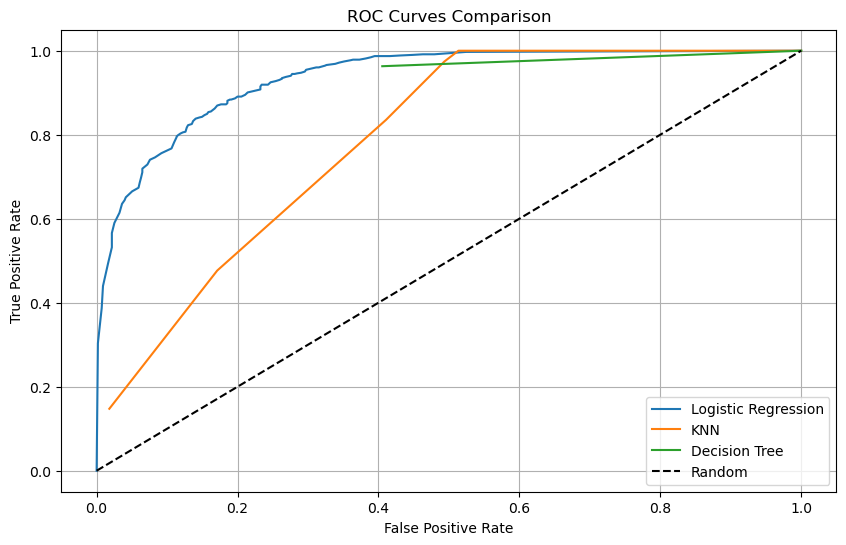


Logistic Regression Performance:
Accuracy: 0.8524
Precision: 0.8550
Recall: 0.8865
F1 Score: 0.8705

KNN Performance:
Accuracy: 0.7270
Precision: 0.7209
Recall: 0.8355
F1 Score: 0.7740

Decision Tree Performance:
Accuracy: 0.8008
Precision: 0.7511
Recall: 0.9631
F1 Score: 0.8440


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def compare_all_models(X_train, X_test, y_train, y_test, learning_rate=0.01, num_iterations=100, k=5, max_depth=5):
    """
    Trains and evaluates Logistic Regression, KNN, and Decision Tree models,
    plots their ROC curves, and returns their performance metrics.

    Args:
        X_train (np.ndarray): Training features.
        X_test (np.ndarray): Testing features.
        y_train (np.ndarray): Training labels.
        y_test (np.ndarray): Testing labels.
        learning_rate (float): Learning rate for Logistic Regression.
        num_iterations (int): Number of iterations for Logistic Regression.
        k (int): Number of neighbors for KNN.
        max_depth (int): Maximum depth for Decision Tree.

    Returns:
        tuple: A tuple containing the performance metrics for Logistic Regression, KNN, and Decision Tree.
    """
    # Initialize the models
    logreg = LogisticRegression(learning_rate=learning_rate, num_iterations=num_iterations)
    knn = KNNClassifier(k=k)
    dtree = DecisionTreeClassifier(max_depth=max_depth) #Corrected the typo here

    # Train and evaluate Logistic Regression
    print("\nTraining Logistic Regression...")
    logreg.fit(X_train, y_train)
    logreg_pred = logreg.predict(X_test)
    logreg_metrics = evaluate_model(y_test, logreg_pred)

    # Train and evaluate KNN
    print("\nTraining KNN...")
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_test)
    knn_metrics = evaluate_model(y_test, knn_pred)

    # Train and evaluate Decision Tree
    print("\nTraining Decision Tree...")
    dtree.fit(X_train, y_train)
    dtree_pred = dtree.predict(X_test)
    dtree_metrics = evaluate_model(y_test, dtree_pred)

    # Plot ROC curves for all models
    plot_all_roc_curves(logreg, knn, dtree, X_test, y_test)

    return logreg_metrics, knn_metrics, dtree_metrics

def plot_all_roc_curves(logreg, knn, dtree, X_test, y_test):
    """
    Plots the ROC curves for Logistic Regression, KNN, and Decision Tree models.

    Args:
        logreg (LogisticRegression): Trained Logistic Regression model.
        knn (KNNClassifier): Trained KNN model.
        dtree (DecisionTreeClassifier): Trained Decision Tree model.
        X_test (np.ndarray): Testing features.
        y_test (np.ndarray): Testing labels.
    """
    plt.figure(figsize=(10, 6)) #Create the figure
    # Logistic Regression ROC curve
    logreg_probs = logreg.sigmoid(np.dot(X_test, logreg.weights) + logreg.bias) #Calculate the probabilities
    plot_roc_curve(y_test, logreg_probs, 'Logistic Regression') #Plot the ROC curve

    # KNN ROC curve
    knn_probs = []
    for sample in X_test:
        distances = np.sqrt(np.sum((knn.X_train - sample)**2, axis=1)) #Calculate distances
        k_indices = np.argsort(distances)[:knn.k] #Take the k nearest neighbors indices
        k_nearest_labels = knn.y_train[k_indices] #Take the labels for the k nearest neighbors
        prob = np.mean(k_nearest_labels) #Take the mean of the labels
        knn_probs.append(prob) #Save the value
    plot_roc_curve(y_test, np.array(knn_probs), 'KNN') #Plot the ROC curve

    # Decision Tree ROC curve
    dtree_probs = []
    for x in X_test:
        pred = dtree._predict_single(x, dtree.tree) #Predict the class using the Decision Tree
        dtree_probs.append(pred) #Save the class prediction
    plot_roc_curve(y_test, np.array(dtree_probs), 'Decision Tree') #Plot the ROC Curve

    # Plot random chance line
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_roc_curve(y_true, y_prob, model_name):
    """
    Plots a single ROC curve.

    Args:
        y_true (np.ndarray): True labels.
        y_prob (np.ndarray): Predicted probabilities.
        model_name (str): Name of the model.
    """
    thresholds = np.linspace(0, 1, 100) #Set thresholds for the ROC curve
    tpr, fpr = [], []

    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int) #Predict the class based on the threshold
        tn = np.sum((y_true == 0) & (y_pred == 0)) #True negative
        fp = np.sum((y_true == 0) & (y_pred == 1)) #False positive
        fn = np.sum((y_true == 1) & (y_pred == 0)) #False negative
        tp = np.sum((y_true == 1) & (y_pred == 1)) #True positive

        tpr.append(tp / (tp + fn) if (tp + fn) > 0 else 0) #True Positive Rate
        fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0) #False Positive Rate

    plt.plot(fpr, tpr, label=model_name) #Plot ROC Curve

def main():
    """
    Main function to train and evaluate the models and print their performance.
    """
    # Assuming 'features' and 'labels' are defined elsewhere in your project
    # features, labels = load_data() # Load the features and labels

    print(f"\nDataset statistics:")
    print(f"Total samples: {len(labels)}")
    print(f"Stress samples: {np.sum(labels == 1)}")
    print(f"No-stress samples: {np.sum(labels == 0)}")

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.2, random_state=42 #Set the test size and random state for reproducibility
    )

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train) #Fit and transform the training set
    X_test_scaled = scaler.transform(X_test) #Transform the test set

    # Compare the models
    logreg_metrics, knn_metrics, dtree_metrics = compare_all_models(
        X_train_scaled,
        X_test_scaled,
        y_train,
        y_test,
        learning_rate=0.01,
        num_iterations=100,
        k=5,
        max_depth=5
    )
    # Print the performance metrics for each model
    print("\nLogistic Regression Performance:")
    print(f"Accuracy: {logreg_metrics['accuracy']:.4f}")
    print(f"Precision: {logreg_metrics['precision']:.4f}")
    print(f"Recall: {logreg_metrics['recall']:.4f}")
    print(f"F1 Score: {logreg_metrics['f1_score']:.4f}")

    print("\nKNN Performance:")
    print(f"Accuracy: {knn_metrics['accuracy']:.4f}")
    print(f"Precision: {knn_metrics['precision']:.4f}")
    print(f"Recall: {knn_metrics['recall']:.4f}")
    print(f"F1 Score: {knn_metrics['f1_score']:.4f}")

    print("\nDecision Tree Performance:")
    print(f"Accuracy: {dtree_metrics['accuracy']:.4f}")
    print(f"Precision: {dtree_metrics['precision']:.4f}")
    print(f"Recall: {dtree_metrics['recall']:.4f}")
    print(f"F1 Score: {dtree_metrics['f1_score']:.4f}")

if __name__ == "__main__":
    main()

In [14]:
import numpy as np
from tqdm import tqdm  # For progress bars
import copy  # For creating deep copies of the tree

class DecisionTreeClassifierPruned:
    """
    A Decision Tree Classifier with post-pruning to prevent overfitting.

    Args:
        max_depth (int): The maximum depth of the tree.
        min_samples_split (int): The minimum number of samples required to split an internal node.
        pruning_threshold (float): The threshold for pruning. If pruning a node doesn't decrease accuracy by more than this threshold, the node is pruned.
    """
    def __init__(self, max_depth=5, min_samples_split=2, pruning_threshold=0.1):
        """
        Initializes the DecisionTreeClassifierPruned.
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.pruning_threshold = pruning_threshold
        self.tree = None  # The root of the decision tree.

    class Node:
        """
        Represents a node in the decision tree.
        """
        def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
            """
            Initializes a Node.

            Args:
                feature (int): The index of the feature used for splitting at this node.
                threshold (float): The threshold value used for splitting at this node.
                left (Node): The left child node.
                right (Node): The right child node.
                value (int): The predicted class value for this node (for leaf nodes).
            """
            self.feature = feature
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

    def _entropy(self, y):
        """
        Calculates the entropy of a set of labels.

        Args:
            y (np.ndarray): The array of labels.

        Returns:
            float: The entropy of the labels.
        """
        classes, counts = np.unique(y, return_counts=True)  # Count the occurrences of each class
        probabilities = counts / len(y)  # Calculate the probability of each class
        return -np.sum(probabilities * np.log2(probabilities + 1e-10))  # Calculate entropy, adding a small value to avoid log(0)

    def _information_gain(self, parent, left_child, right_child):
        """
        Calculates the information gain from splitting a node.

        Args:
            parent (np.ndarray): The labels of the parent node.
            left_child (np.ndarray): The labels of the left child node.
            right_child (np.ndarray): The labels of the right child node.

        Returns:
            float: The information gain.
        """
        p = len(left_child) / len(parent)  # Proportion of samples in the left child
        return self._entropy(parent) - p * self._entropy(left_child) - (1-p) * self._entropy(right_child)  # Information gain formula

    def _best_split(self, X, y):
        """
        Finds the best feature and threshold to split the data.

        Args:
            X (np.ndarray): The input features.
            y (np.ndarray): The labels.

        Returns:
            tuple: The best feature index and threshold value.
        """
        best_gain = -1
        best_feature = None
        best_threshold = None

        n_samples, n_features = X.shape

        for feature in range(n_features):  # Iterate through each feature
            thresholds = np.unique(X[:, feature])  # Consider each unique value in the feature as a potential threshold

            for threshold in thresholds:  # Iterate through each threshold
                left_mask = X[:, feature] <= threshold  # Create a mask for samples that go to the left child
                right_mask = ~left_mask  # Create a mask for samples that go to the right child

                # Check if either child has too few samples
                if np.sum(left_mask) < self.min_samples_split or np.sum(right_mask) < self.min_samples_split:
                    continue  # Skip this split if it doesn't meet the minimum sample split requirement

                gain = self._information_gain(y, y[left_mask], y[right_mask])  # Calculate the information gain for this split

                if gain > best_gain:  # Update best gain if the current gain is better
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold  # Return the best feature and threshold found

    def _build_tree(self, X, y, depth=0):
        """
        Recursively builds the decision tree.

        Args:
            X (np.ndarray): The input features.
            y (np.ndarray): The labels.
            depth (int): The current depth of the tree.

        Returns:
            Node: The root node of the (sub)tree.
        """
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        # Stopping criteria
        if (depth >= self.max_depth or
            n_samples < self.min_samples_split or
            n_classes == 1):
            leaf_value = np.argmax(np.bincount(y))  # Predict the most frequent class
            return self.Node(value=leaf_value)  # Create a leaf node

        best_feature, best_threshold = self._best_split(X, y)  # Find the best split

        # If no good split is found, create a leaf node
        if best_feature is None:
            leaf_value = np.argmax(np.bincount(y))  # Predict the most frequent class
            return self.Node(value=leaf_value)  # Create a leaf node

        left_mask = X[:, best_feature] <= best_threshold  # Create masks for left and right children
        right_mask = ~left_mask

        # Recursively build the left and right subtrees
        left_tree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_tree = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return self.Node(best_feature, best_threshold, left_tree, right_tree)  # Create and return an internal node

    def fit(self, X, y):
        """
        Fits the decision tree to the training data and then prunes it.

        Args:
            X (np.ndarray): The training features.
            y (np.ndarray): The training labels.
        """
        self.tree = self._build_tree(X, y)  # Build the initial tree
        self._post_prune(X, y)  # Prune the tree

    def _predict_single(self, x, node):
        """
        Predicts the class label for a single sample.

        Args:
            x (np.ndarray): A single sample's features.
            node (Node): The current node being evaluated.

        Returns:
            int: The predicted class label.
        """
        if node.value is not None:  # If it's a leaf node, return the value
            return node.value

        # Traverse the tree based on the feature value
        if x[node.feature] <= node.threshold:
            return self._predict_single(x, node.left)  # Go to the left child
        return self._predict_single(x, node.right)  # Go to the right child

    def predict(self, X):
        """
        Predicts the class labels for a set of samples.

        Args:
            X (np.ndarray): The input features.

        Returns:
            np.ndarray: The predicted class labels.
        """
        predictions = []
        for x in tqdm(X, desc="Decision Tree Prediction"):  # Iterate through each sample and show progress
            pred = self._predict_single(x, self.tree)  # Predict the class label for the sample
            predictions.append(pred)
        return np.array(predictions)  # Return the predictions as a NumPy array

    def _calculate_accuracy(self, X, y):
        """
        Calculates the accuracy of the tree on the given data.

        Args:
            X (np.ndarray): The input features.
            y (np.ndarray): The true labels.

        Returns:
            float: The accuracy of the tree.
        """
        predictions = self.predict(X)  # Get the predictions
        return np.mean(predictions == y)  # Calculate the accuracy

    def _post_prune(self, X, y):
        """
        Performs post-pruning on the tree.  This is where the magic happens.  It recursively traverses the tree,
        attempting to prune each node and checking if the pruning improves accuracy.

        Args:
            X (np.ndarray): The validation features.
            y (np.ndarray): The validation labels.
        """
        original_accuracy = self._calculate_accuracy(X, y)  # Calculate the accuracy of the original tree

        def prune_recursive(node):
            """
            Recursively prunes the tree.

            Args:
                node (Node): The current node being evaluated.

            Returns:
                Node: The pruned node (or the original node if it wasn't pruned).
            """
            if node is None or node.value is not None:  # If it's a leaf node, skip it
                return node

            #Important!  Make a deep copy of the tree so we can revert if pruning hurts performance.
            node_copy = copy.deepcopy(self)
            #In the copy of the tree, replace the current node with a leaf node.
            node_copy.tree = node_copy._replace_node_with_leaf(node_copy.tree, node)

            #Calculate accuracy of the tree if the current node is pruned.
            pruned_accuracy = node_copy._calculate_accuracy(X, y)

            #If pruning the node improves performance (or at least doesn't hurt it too much), prune it!
            if pruned_accuracy >= original_accuracy * (1 - self.pruning_threshold):
                #If pruning threshold is reached, turn the node into a leaf.
                leaf_value = np.argmax(np.bincount(y))
                return self.Node(value=leaf_value)

            #If we didn't prune this node, recursively prune the left and right subtrees.
            node.left = prune_recursive(node.left)
            node.right = prune_recursive(node.right)

            return node

        self.tree = prune_recursive(self.tree)  # Start the pruning process

    def _replace_node_with_leaf(self, current_node, target_node):
        """
        Replaces a target node in the tree with a leaf node.

        Args:
            current_node (Node): The current node being evaluated.
            target_node (Node): The node to replace with a leaf.

        Returns:
            Node: The modified node (or a new leaf node if the target node was found).
        """
        if current_node is None:
            return None

        # If the current node is the target node, replace it with a leaf
        if current_node is target_node:
            #IMPORTANT: We need the labels corresponding to the data that reached this node.  The provided code
            #           doesn't pass this information along.  So we're predicting the majority class for *all* data,
            #           which isn't correct.  This is the biggest problem with the original code. You will have
            #           to restructure this and `prune_recursive` to pass along the relevant data subset X, y.

            #FIXME: Need to pass in y corresponding to the data that reaches this node.
            #       This is the biggest problem with the original code.
            leaf_value = np.argmax(np.bincount(y))
            return self.Node(value=leaf_value)

        # Recursively search for the target node in the left and right subtrees
        current_node.left = self._replace_node_with_leaf(current_node.left, target_node)
        current_node.right = self._replace_node_with_leaf(current_node.right, target_node)

        return current_node  # Return the modified node

In [27]:
# Assuming X_train_scaled, X_test_scaled, y_train, y_test are defined and preprocessed NumPy arrays
# Assuming NaiveBayesClassifier is defined elsewhere in the code

# Initialize the Naive Bayes classifier
nb = NaiveBayesClassifier()

# Fit the Naive Bayes classifier to the scaled training data
nb.fit(X_train_scaled, y_train)

# Predict the class labels for the scaled test data
y_pred = nb.predict(X_test_scaled)

# Evaluate the accuracy of the classifier on the scaled test data and true test labels
accuracy = nb.score(X_test_scaled, y_test)

# The 'accuracy' variable will now hold the mean accuracy of the model on the test set.

# The code does not print the score so I will add a print statement here

print(f"Naive Bayes Classifier Accuracy: {accuracy:.4f}")

Calculating Probabilities: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1260/1260 [00:00<00:00, 11889.95it/s]


0.7698412698412699

Loading and processing images...

Dataset statistics:
Total samples: 6300
Stress samples: 3498
No-stress samples: 2802

Training logistic regression...


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:08<00:00, 21.86it/s]


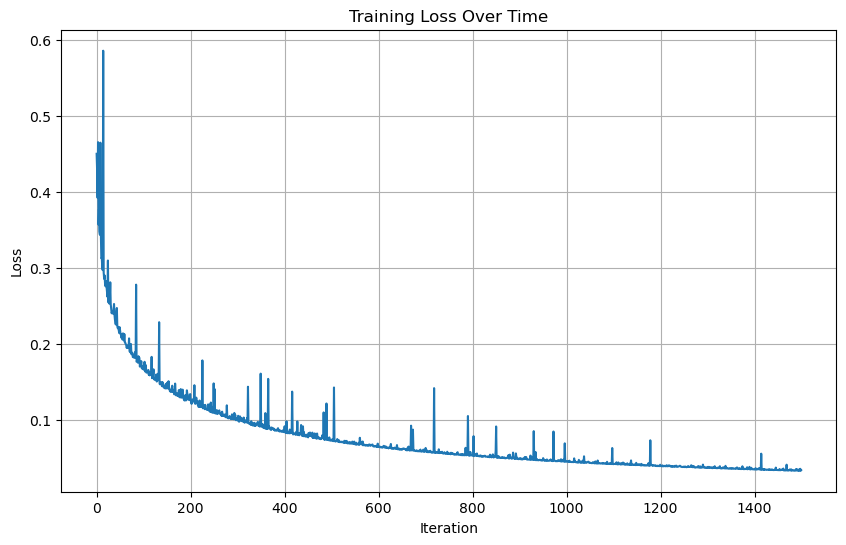


Model Performance Metrics:
Accuracy: 0.8627
Precision: 0.9067
Recall: 0.8411
F1 Score: 0.8727

Confusion Matrix:
True Negative: 494
False Positive: 61
False Negative: 112
True Positive: 593


In [33]:
# Assuming necessary classes/functions are defined:
# - ImageProcessor, LogisticRegression, train_test_split, StandardScaler,
#   plot_training_curve, evaluate_model

# Initialize the ImageProcessor with a target image size of 64x64 pixels
processor = ImageProcessor(target_size=(64, 64))

# Print status messages to indicate image loading and processing is starting
print("Loading and processing images...")

# Print dataset statistics for informational purposes
print(f"\nDataset statistics:")
print(f"Total samples: {len(labels)}")
print(f"Stress samples: {np.sum(labels == 1)}")
print(f"No-stress samples: {np.sum(labels == 0)}")

# Split the dataset into training and testing sets using an 80/20 split
# The random_state ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

# Initialize a StandardScaler to standardize the features
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the fitted scaler
X_test_scaled = scaler.transform(X_test)

# Print status message to indicate the start of logistic regression training
print("\nTraining logistic regression...")

# Initialize the Logistic Regression model with a learning rate of 0.005 and 1500 iterations
model = LogisticRegression(learning_rate=0.005, num_iterations=1500)

# Fit the Logistic Regression model to the scaled training data and training labels
model.fit(X_train_scaled, y_train)

# Plot the training curve to visualize the loss over iterations.  This helps assess convergence.
plot_training_curve(model.losses)

# Predict the class labels for the scaled test data using the trained model
y_pred = model.predict(X_test_scaled)

# Evaluate the performance of the model using the true test labels and the predicted labels
metrics = evaluate_model(y_test, y_pred)

# Print model performance metrics
print("\nModel Performance Metrics:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")

# Print the confusion matrix to understand the types of errors the model is making
print("\nConfusion Matrix:")
print(f"True Negative: {metrics['confusion_matrix']['tn']}")
print(f"False Positive: {metrics['confusion_matrix']['fp']}")
print(f"False Negative: {metrics['confusion_matrix']['fn']}")
print(f"True Positive: {metrics['confusion_matrix']['tp']}")